core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:53:44.819' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

  Driver                LapTime Compound  TyreLife TrackStatus
1    VER 0 days 00:01:19.367000   MEDIUM       2.0           1
2    VER 0 days 00:01:19.074000   MEDIUM       3.0           1
3    VER 0 days 00:01:18.129000   MEDIUM       4.0           1
4    VER 0 days 00:01:18.019000   MEDIUM       5.0           1
5    VER 0 days 00:01:17.640000   MEDIUM       6.0           1


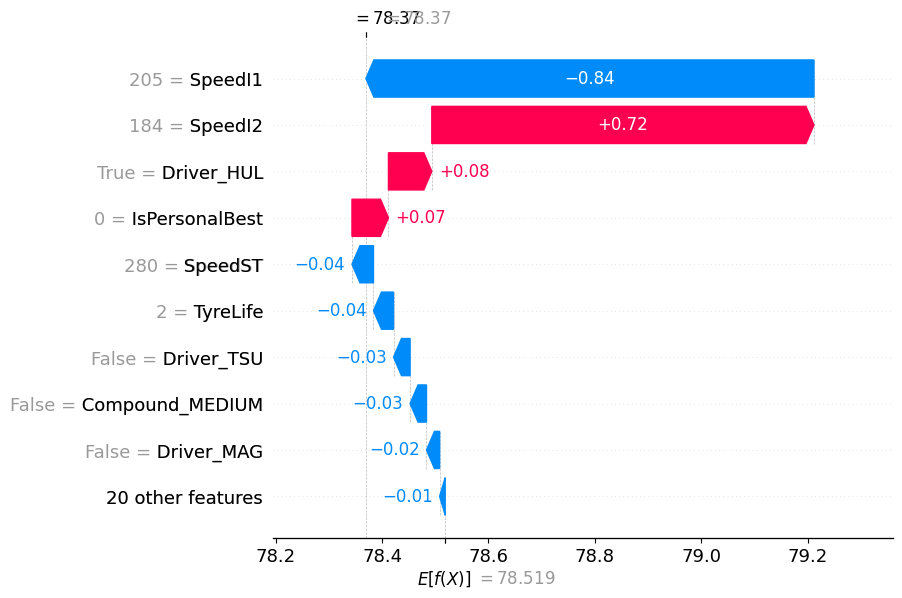

Sample prediction vs actual:
Predicted: 78.370s | Actual: 77.221s
Predicted: 79.447s | Actual: 79.699s
Predicted: 79.864s | Actual: 79.611s
Predicted: 79.022s | Actual: 78.265s
Predicted: 77.215s | Actual: 77.075s


In [4]:
# 🛠️ Setup
!pip install fastf1 xgboost shap matplotlib scikit-learn pandas --quiet

import fastf1
from fastf1.plotting import setup_mpl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

# 🏎️ Step 1: Load F1 Data
import os
os.makedirs('/content/f1_cache', exist_ok=True)  # ✅ Create folder if it doesn't exist
fastf1.Cache.enable_cache('/content/f1_cache')   # ✅ Enable cache

session = fastf1.get_session(2023, 'Monaco', 'R')  # 2023 Monaco GP Race
session.load()

laps = session.laps
laps = laps.pick_quicklaps()
print(laps[['Driver', 'LapTime', 'Compound', 'TyreLife', 'TrackStatus']].head())

# 🧠 Step 2: Feature Engineering
# 🧠 Step 2: Feature Engineering
df = laps[[
    'Driver', 'LapTime', 'Compound', 'TyreLife', 'TrackStatus',
    'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest'
]]

df = df.dropna()
df['LapTimeSec'] = df['LapTime'].dt.total_seconds()
df['IsPersonalBest'] = df['IsPersonalBest'].astype(int)  # ✅ Convert to int

df = pd.get_dummies(df, columns=['Compound', 'TrackStatus', 'Driver'], drop_first=True)

features = df.drop(columns=['LapTime', 'LapTimeSec'])
target = df['LapTimeSec']

# 📈 Step 3: Train Model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# 🎯 Step 4: Predict + SHAP Explainability
preds = model.predict(X_test)
explainer = shap.Explainer(model)
shap_values = explainer(X_test[:10])

shap.plots.waterfall(shap_values[0])

# 🔮 Sample Output
print("Sample prediction vs actual:")
for i in range(5):
    print(f"Predicted: {preds[i]:.3f}s | Actual: {y_test.iloc[i]:.3f}s")
